In [2]:
"""
Metaheuristic Optimization Algorithms from Scratch
=================================================

This module implements two popular metaheuristic optimization algorithms:
1. Genetic Algorithm (GA)
2. Particle Swarm Optimization (PSO)

Both implementations are created from scratch without relying on specialized libraries,
making them ideal for educational purposes.

We'll demonstrate these algorithms on two classic optimization problems:
- Knapsack Problem (0-1 binary problem)
- Traveling Salesman Problem (TSP - permutation problem)
"""

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import List, Tuple, Dict, Callable, Any, Union
import copy

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# For better visualizations
plt.style.use('ggplot')

#===========================================================
# GENETIC ALGORITHM FROM SCRATCH
#===========================================================

class GeneticAlgorithm:
    """
    Generic Genetic Algorithm implementation from scratch.
    
    This class implements a customizable GA that can work with 
    different representation schemes and genetic operators.
    """
    
    def __init__(self, 
                 pop_size: int = 100,
                 max_generations: int = 100,
                 crossover_rate: float = 0.7,
                 mutation_rate: float = 0.2,
                 selection_tournament_size: int = 3,
                 elitism: int = 1):
        """
        Initialize the GA with parameters.
        
        Args:
            pop_size: Population size
            max_generations: Maximum number of generations
            crossover_rate: Probability of crossover
            mutation_rate: Probability of mutation
            selection_tournament_size: Tournament size for selection
            elitism: Number of best individuals to preserve
        """
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.tournament_size = selection_tournament_size
        self.elitism = elitism
        
        # These will be set in the solve method
        self.init_individual = None
        self.evaluate = None
        self.crossover = None
        self.mutate = None
        self.problem_type = None
        
        # For tracking
        self.best_fitness_history = []
        self.avg_fitness_history = []
    
    def solve(self,
              init_individual: Callable[[], List],
              evaluate: Callable[[List], float],
              crossover: Callable[[List, List], Tuple[List, List]],
              mutate: Callable[[List], List],
              problem_type: str = "minimize") -> Tuple[List, float]:
        """
        Solve an optimization problem using GA.
        
        Args:
            init_individual: Function that returns a new random individual
            evaluate: Function that evaluates an individual and returns fitness
            crossover: Function that performs crossover on two parents
            mutate: Function that mutates an individual
            problem_type: "minimize" or "maximize"
            
        Returns:
            Tuple of (best individual, best fitness)
        """
        self.init_individual = init_individual
        self.evaluate = evaluate
        self.crossover = crossover
        self.mutate = mutate
        self.problem_type = problem_type
        
        # Initialize population
        population = [init_individual() for _ in range(self.pop_size)]
        
        # Evaluate initial population
        fitness = [evaluate(ind) for ind in population]
        
        # Run the evolutionary loop
        for generation in range(self.max_generations):
            # Keep track of best and average fitness
            if problem_type == "minimize":
                best_idx = np.argmin(fitness)
                best_fitness = min(fitness)
                avg_fitness = np.mean(fitness)
            else:  # maximize
                best_idx = np.argmax(fitness)
                best_fitness = max(fitness)
                avg_fitness = np.mean(fitness)
                
            self.best_fitness_history.append(best_fitness)
            self.avg_fitness_history.append(avg_fitness)
            
            # Create a new generation
            new_population = []
            
            # Elitism: keep the best individuals
            sorted_indices = np.argsort(fitness)
            if problem_type == "maximize":
                sorted_indices = sorted_indices[::-1]  # Reverse for maximization
                
            for i in range(self.elitism):
                new_population.append(copy.deepcopy(population[sorted_indices[i]]))
            
            # Fill the rest of the population
            while len(new_population) < self.pop_size:
                # Selection
                parent1 = self._tournament_selection(population, fitness)
                parent2 = self._tournament_selection(population, fitness)
                
                # Crossover
                if random.random() < self.crossover_rate:
                    offspring1, offspring2 = self.crossover(parent1, parent2)
                else:
                    offspring1, offspring2 = copy.deepcopy(parent1), copy.deepcopy(parent2)
                
                # Mutation
                if random.random() < self.mutation_rate:
                    offspring1 = self.mutate(offspring1)
                if random.random() < self.mutation_rate:
                    offspring2 = self.mutate(offspring2)
                
                # Add to new population
                new_population.append(offspring1)
                if len(new_population) < self.pop_size:
                    new_population.append(offspring2)
            
            # Replace old population
            population = new_population
            
            # Evaluate new population
            fitness = [self.evaluate(ind) for ind in population]
        
        # Return best individual from final population
        if problem_type == "minimize":
            best_idx = np.argmin(fitness)
        else:
            best_idx = np.argmax(fitness)
            
        return population[best_idx], fitness[best_idx]
    
    def _tournament_selection(self, population: List, fitness: List) -> List:
        """Tournament selection for choosing a parent."""
        # Randomly select tournament_size individuals
        tournament_indices = random.sample(range(len(population)), self.tournament_size)
        tournament_fitness = [fitness[i] for i in tournament_indices]
        
        # Select the best from the tournament
        if self.problem_type == "minimize":
            winner_idx = tournament_indices[np.argmin(tournament_fitness)]
        else:
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            
        return copy.deepcopy(population[winner_idx])
    
    def plot_convergence(self, title: str = "GA Convergence"):
        """Plot the convergence of the algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_fitness_history, 'r-', label='Best Fitness')
        plt.plot(self.avg_fitness_history, 'b-', label='Average Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#===========================================================
# PARTICLE SWARM OPTIMIZATION FROM SCRATCH
#===========================================================

class ParticleSwarmOptimization:
    """
    Generic Particle Swarm Optimization implementation from scratch.
    
    This class implements a customizable PSO that can work with 
    different types of problems and update rules.
    """
    
    def __init__(self,
                 swarm_size: int = 50,
                 max_iterations: int = 100,
                 inertia_weight: float = 0.5,
                 cognitive_coef: float = 1.5,
                 social_coef: float = 1.5):
        """
        Initialize the PSO algorithm with parameters.
        
        Args:
            swarm_size: Number of particles in the swarm
            max_iterations: Maximum number of iterations
            inertia_weight: Weight for the particle's velocity (w)
            cognitive_coef: Cognitive coefficient (c1)
            social_coef: Social coefficient (c2)
        """
        self.swarm_size = swarm_size
        self.max_iterations = max_iterations
        self.w = inertia_weight
        self.c1 = cognitive_coef
        self.c2 = social_coef
        
        # These will be set in the solve method
        self.init_particle = None
        self.evaluate = None
        self.update_velocity = None
        self.update_position = None
        self.problem_type = None
        
        # For tracking
        self.best_fitness_history = []
        self.avg_fitness_history = []
    
    def solve(self,
              init_particle: Callable[[], Tuple[Any, Any]],
              evaluate: Callable[[Any], float],
              update_velocity: Callable[[Any, Any, Any, float, float, float], Any],
              update_position: Callable[[Any, Any], Any],
              problem_type: str = "minimize") -> Tuple[Any, float]:
        """
        Solve an optimization problem using PSO.
        
        Args:
            init_particle: Function that returns a tuple of (position, velocity)
            evaluate: Function that evaluates a position and returns fitness
            update_velocity: Function that updates a particle's velocity
            update_position: Function that updates a particle's position
            problem_type: "minimize" or "maximize"
            
        Returns:
            Tuple of (best position, best fitness)
        """
        self.init_particle = init_particle
        self.evaluate = evaluate
        self.update_velocity = update_velocity
        self.update_position = update_position
        self.problem_type = problem_type
        
        # Initialize swarm
        particles = []
        fitness = []
        personal_best_positions = []
        personal_best_fitness = []
        
        for _ in range(self.swarm_size):
            # Initialize position and velocity
            position, velocity = init_particle()
            particles.append((position, velocity))
            
            # Evaluate initial position
            particle_fitness = evaluate(position)
            fitness.append(particle_fitness)
            
            # Initialize personal best
            personal_best_positions.append(copy.deepcopy(position))
            personal_best_fitness.append(particle_fitness)
        
        # Initialize global best
        if problem_type == "minimize":
            global_best_idx = np.argmin(personal_best_fitness)
        else:
            global_best_idx = np.argmax(personal_best_fitness)
            
        global_best_position = copy.deepcopy(personal_best_positions[global_best_idx])
        global_best_fitness = personal_best_fitness[global_best_idx]
        
        # Run the PSO loop
        for iteration in range(self.max_iterations):
            # Update each particle
            for i in range(self.swarm_size):
                position, velocity = particles[i]
                
                # Update velocity using personal and global best
                new_velocity = self.update_velocity(
                    velocity, 
                    position, 
                    personal_best_positions[i],
                    global_best_position,
                    self.w, self.c1, self.c2
                )
                
                # Update position using new velocity
                new_position = self.update_position(position, new_velocity)
                
                # Update particle
                particles[i] = (new_position, new_velocity)
                
                # Evaluate new position
                particle_fitness = self.evaluate(new_position)
                fitness[i] = particle_fitness
                
                # Update personal best
                if (problem_type == "minimize" and particle_fitness < personal_best_fitness[i]) or \
                   (problem_type == "maximize" and particle_fitness > personal_best_fitness[i]):
                    personal_best_positions[i] = copy.deepcopy(new_position)
                    personal_best_fitness[i] = particle_fitness
                    
                    # Update global best
                    if (problem_type == "minimize" and particle_fitness < global_best_fitness) or \
                       (problem_type == "maximize" and particle_fitness > global_best_fitness):
                        global_best_position = copy.deepcopy(new_position)
                        global_best_fitness = particle_fitness
            
            # Track best and average fitness
            if problem_type == "minimize":
                iteration_best = min(fitness)
            else:
                iteration_best = max(fitness)
                
            iteration_avg = np.mean(fitness)
            self.best_fitness_history.append(global_best_fitness)
            self.avg_fitness_history.append(iteration_avg)
        
        return global_best_position, global_best_fitness
    
    def plot_convergence(self, title: str = "PSO Convergence"):
        """Plot the convergence of the algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_fitness_history, 'r-', label='Global Best Fitness')
        plt.plot(self.avg_fitness_history, 'b-', label='Average Fitness')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#===========================================================
# KNAPSACK PROBLEM
#===========================================================

def generate_knapsack_instance(n: int = 30, seed: int = 42) -> Tuple[np.ndarray, np.ndarray, int]:
    """Generate a random knapsack problem instance."""
    random.seed(seed)
    np.random.seed(seed)
    
    # Generate weights between 1 and 10
    weights = np.random.randint(1, 11, size=n)
    
    # Generate values between 5 and 50
    values = np.random.randint(5, 51, size=n)
    
    # Set capacity to ~40% of total weight
    capacity = int(0.4 * np.sum(weights))
    
    return weights, values, capacity

def print_knapsack_solution(solution: List[int], weights: np.ndarray, 
                           values: np.ndarray, capacity: int, time_taken: float) -> Tuple[float, float]:
    """Print details of a knapsack solution."""
    # Convert binary representation to indices of selected items
    if all(isinstance(x, int) and x in [0, 1] for x in solution):
        selected_items = [i for i, x in enumerate(solution) if x == 1]
    else:
        selected_items = solution  # Already a list of indices
        
    total_weight = sum(weights[i] for i in selected_items)
    total_value = sum(values[i] for i in selected_items)
    
    print(f"Time taken: {time_taken:.4f} seconds")
    print(f"Selected items: {selected_items}")
    print(f"Total items selected: {len(selected_items)}")
    print(f"Total weight: {total_weight}/{capacity} ({total_weight/capacity*100:.1f}%)")
    print(f"Total value: {total_value}")
    print("-" * 50)
    
    return total_value, time_taken

def visualize_knapsack_results(results: Dict[str, Dict[str, float]], 
                              title: str = "Knapsack Problem Results") -> None:
    """Visualize comparison between different methods."""
    methods = list(results.keys())
    values = [results[m]["value"] for m in methods]
    times = [results[m]["time"] for m in methods]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot total values
    ax1.bar(methods, values, color=['green', 'orange'])
    ax1.set_title('Total Value Comparison')
    ax1.set_ylabel('Total Value')
    for i, v in enumerate(values):
        ax1.text(i, v + 5, str(int(v)), ha='center')
    
    # Plot computation times
    ax2.bar(methods, times, color=['green', 'orange'])
    ax2.set_title('Computation Time Comparison')
    ax2.set_ylabel('Time (seconds)')
    for i, t in enumerate(times):
        ax2.text(i, t * 1.1, f"{t:.4f}s", ha='center')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#----------------------------------------------------------
# Genetic Algorithm for Knapsack
#----------------------------------------------------------

def solve_knapsack_ga_from_scratch(weights: np.ndarray, values: np.ndarray, capacity: int,
                                  pop_size: int = 100, max_generations: int = 100) -> Tuple[List[int], float]:
    """Solve knapsack problem using GA from scratch."""
    start_time = time.time()
    n = len(weights)
    
    # Initialize a GA with parameters
    ga = GeneticAlgorithm(
        pop_size=pop_size,
        max_generations=max_generations,
        crossover_rate=0.7,
        mutation_rate=0.2,
        selection_tournament_size=3,
        elitism=2
    )
    
    # Define functions for the GA
    def init_individual():
        """Create a random binary chromosome."""
        return [random.randint(0, 1) for _ in range(n)]
    
    def evaluate(individual):
        """Evaluate fitness (total value) with penalty for exceeding capacity."""
        total_weight = sum(individual[i] * weights[i] for i in range(n))
        total_value = sum(individual[i] * values[i] for i in range(n))
        
        if total_weight > capacity:
            # Apply penalty
            return -1  # Return very poor fitness
        
        return total_value
    
    def crossover(parent1, parent2):
        """Two-point crossover."""
        point1 = random.randint(0, n-1)
        point2 = random.randint(0, n-1)
        
        if point1 > point2:
            point1, point2 = point2, point1
            
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        
        return child1, child2
    
    def mutate(individual):
        """Bit-flip mutation for each gene with probability 1/n."""
        for i in range(len(individual)):
            if random.random() < 1.0/n:
                individual[i] = 1 - individual[i]  # Flip bit
        return individual
    
    # Solve using the GA
    best_solution, best_fitness = ga.solve(
        init_individual=init_individual,
        evaluate=evaluate,
        crossover=crossover,
        mutate=mutate,
        problem_type="maximize"
    )
    
    # Convert binary solution to list of selected items
    selected_items = [i for i, bit in enumerate(best_solution) if bit == 1]
    
    end_time = time.time()
    
    # Plot convergence
    ga.plot_convergence(title="Genetic Algorithm Convergence for Knapsack Problem")
    
    return selected_items, end_time - start_time

#----------------------------------------------------------
# PSO for Knapsack
#----------------------------------------------------------
# Fix for the knapsack PSO algorithm

def solve_knapsack_pso_from_scratch(weights, values, capacity, swarm_size=50, max_iterations=100):
    """Solve knapsack problem using PSO from scratch."""
    start_time = time.time()
    n = len(weights)
    
    # Initialize PSO
    pso = ParticleSwarmOptimization(
        swarm_size=swarm_size,
        max_iterations=max_iterations,
        inertia_weight=0.5,
        cognitive_coef=1.5,
        social_coef=1.5
    )
    
    # Define functions for PSO
    def init_particle():
        """Initialize position (continuous) and velocity."""
        position = np.random.random(n)  # Continuous values in [0, 1]
        velocity = np.random.uniform(-0.1, 0.1, n)  # Small random velocities
        return position, velocity
    
    def evaluate(position):
        """Evaluate fitness with penalty for exceeding capacity."""
        # Convert continuous position to binary by thresholding
        binary = (position > 0.5).astype(int)
        
        total_weight = sum(binary[i] * weights[i] for i in range(n))
        total_value = sum(binary[i] * values[i] for i in range(n))
        
        if total_weight > capacity:
            # Apply penalty
            return -1  # Return very poor fitness
        
        return total_value
    
    def update_velocity(velocity, position, p_best, g_best, w, c1, c2):
        """Update velocity according to PSO equation."""
        r1 = np.random.random(n)
        r2 = np.random.random(n)
        
        new_velocity = (w * velocity + 
                       c1 * r1 * (p_best - position) +
                       c2 * r2 * (g_best - position))
        
        # Clamp velocity to prevent explosion
        new_velocity = np.clip(new_velocity, -0.5, 0.5)
        
        return new_velocity
    
    def update_position(position, velocity):
        """Update position according to velocity."""
        # For continuous PSO, simply add velocity to position
        new_position = position + velocity
        
        # Clamp position to [0, 1]
        new_position = np.clip(new_position, 0, 1)
        
        return new_position
    
    # Solve using PSO
    best_position, best_fitness = pso.solve(
        init_particle=init_particle,
        evaluate=evaluate,
        update_velocity=update_velocity,
        update_position=update_position,
        problem_type="maximize"
    )
    
    # Convert continuous solution to binary and then to indices
    binary_solution = (best_position > 0.5).astype(int)
    selected_items = [i for i, bit in enumerate(binary_solution) if bit == 1]
    
    end_time = time.time()
    
    # Plot convergence
    pso.plot_convergence(title="PSO Convergence for Knapsack Problem")
    
    return selected_items, end_time - start_time

#===========================================================
# TRAVELING SALESMAN PROBLEM (TSP)
#===========================================================

def generate_tsp_instance(n: int = 20, seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """Generate a random TSP instance."""
    random.seed(seed)
    np.random.seed(seed)
    
    # Generate random coordinates in [0, 100] x [0, 100]
    points = np.random.rand(n, 2) * 100
    
    # Calculate distance matrix
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                # Euclidean distance
                distances[i, j] = np.sqrt(np.sum((points[i] - points[j])**2))
            else:
                distances[i, j] = 0
                
    return points, distances

def plot_tsp_solution(points: np.ndarray, tour: List[int], title: str) -> None:
    """Plot a TSP solution."""
    plt.figure(figsize=(8, 6))
    
    # Plot points
    plt.scatter(points[:, 0], points[:, 1], s=50)
    
    # Plot tour
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        plt.plot([points[tour[i], 0], points[tour[j], 0]],
                [points[tour[i], 1], points[tour[j], 1]], 'r-')
    
    # Label points
    for i, point in enumerate(points):
        plt.text(point[0] + 1, point[1] + 1, str(i))
        
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.tight_layout()
    
def print_tsp_solution(tour: List[int], distances: np.ndarray, time_taken: float) -> Tuple[float, float]:
    """Print details of a TSP solution."""
    tour_length = sum(distances[tour[i], tour[(i + 1) % len(tour)]] 
                     for i in range(len(tour)))
    
    print(f"Time taken: {time_taken:.4f} seconds")
    print(f"Tour: {tour}")
    print(f"Tour length: {tour_length:.2f}")
    print("-" * 50)
    
    return tour_length, time_taken

def visualize_tsp_results(results: Dict[str, Dict[str, float]], title: str = "TSP Results") -> None:
    """Visualize comparison between different methods."""
    methods = list(results.keys())
    lengths = [results[m]["length"] for m in methods]
    times = [results[m]["time"] for m in methods]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot tour lengths
    ax1.bar(methods, lengths, color=['green', 'orange'])
    ax1.set_title('Tour Length Comparison')
    ax1.set_ylabel('Tour Length')
    for i, v in enumerate(lengths):
        ax1.text(i, v + 1, f"{v:.1f}", ha='center')
    
    # Plot computation times
    ax2.bar(methods, times, color=['green', 'orange'])
    ax2.set_title('Computation Time Comparison')
    ax2.set_ylabel('Time (seconds)')
    for i, t in enumerate(times):
        ax2.text(i, t * 1.1, f"{t:.4f}s", ha='center')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#----------------------------------------------------------
# Genetic Algorithm for TSP
#----------------------------------------------------------

def solve_tsp_ga_from_scratch(distances: np.ndarray, 
                             pop_size: int = 100, max_generations: int = 200) -> Tuple[List[int], float]:
    """Solve the TSP using GA from scratch."""
    start_time = time.time()
    n = distances.shape[0]
    
    # Initialize GA
    ga = GeneticAlgorithm(
        pop_size=pop_size,
        max_generations=max_generations,
        crossover_rate=0.7,
        mutation_rate=0.3,
        selection_tournament_size=3,
        elitism=2
    )
    
    # Define functions for GA
    def init_individual():
        """Create a random permutation."""
        perm = list(range(n))
        random.shuffle(perm)
        return perm
    
    def evaluate(individual):
        """Calculate total tour length."""
        tour_length = sum(distances[individual[i], individual[(i + 1) % n]] 
                         for i in range(n))
        return tour_length
    
    def crossover(parent1, parent2):
        """Ordered crossover (OX) for permutations."""
        # Select two random crossover points
        point1 = random.randint(0, n-1)
        point2 = random.randint(0, n-1)
        
        if point1 > point2:
            point1, point2 = point2, point1
        
        # Create children using ordered crossover
        def ox_child(p1, p2):
            # Keep a portion from the first parent
            child = [None] * len(p1)
            # Copy the segment between points
            for i in range(point1, point2 + 1):
                child[i] = p1[i]
            
            # Fill remaining positions with cities from the second parent
            p2_idx = 0
            child_idx = (point2 + 1) % n
            
            while None in child:
                if p2[p2_idx] not in child:
                    child[child_idx] = p2[p2_idx]
                    child_idx = (child_idx + 1) % n
                p2_idx = (p2_idx + 1) % n
                
            return child
        
        child1 = ox_child(parent1, parent2)
        child2 = ox_child(parent2, parent1)
        
        return child1, child2
    
    def mutate(individual):
        """Swap mutation: swap two random cities."""
        idx1 = random.randint(0, n-1)
        idx2 = random.randint(0, n-1)
        
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        
        return individual
    
    # Solve using GA
    best_solution, best_fitness = ga.solve(
        init_individual=init_individual,
        evaluate=evaluate,
        crossover=crossover,
        mutate=mutate,
        problem_type="minimize"
    )
    
    end_time = time.time()
    
    # Plot convergence
    ga.plot_convergence(title="Genetic Algorithm Convergence for TSP")
    
    return best_solution, end_time - start_time

#----------------------------------------------------------
# PSO for TSP
#----------------------------------------------------------
def solve_tsp_pso_from_scratch(distances, swarm_size=50, max_iterations=100):
    """Solve the TSP using PSO from scratch with path representation."""
    start_time = time.time()
    n = distances.shape[0]
    
    # Initialize PSO
    pso = ParticleSwarmOptimization(
        swarm_size=swarm_size,
        max_iterations=max_iterations,
        inertia_weight=0.5,
        cognitive_coef=1.5,
        social_coef=1.5
    )
    
    # Define functions for PSO
    def init_particle():
        """Initialize position as permutation and velocity as list of swaps."""
        # Position is a permutation
        position = list(range(n))
        random.shuffle(position)
        
        # Velocity is an empty list of swaps
        velocity = []
        
        return position, velocity
    
    def evaluate(position):
        """Calculate tour length."""
        tour_length = sum(distances[position[i], position[(i + 1) % n]] 
                         for i in range(n))
        return tour_length
    
    def update_velocity(velocity, position, p_best, g_best, w, c1, c2):
        """
        Update "velocity" for permutation representation in TSP.
        
        For permutation problems, velocity is represented as a list of swaps.
        We generate swaps to move from current position towards personal and global best.
        """
        new_velocity = []
        
        # Apply inertia - keep some previous swaps
        if random.random() < w and velocity:
            # Keep a random subset of previous swaps
            num_swaps = max(1, int(len(velocity) * w))
            indices = random.sample(range(len(velocity)), min(num_swaps, len(velocity)))
            for idx in indices:
                new_velocity.append(velocity[idx])
        
        # Move towards personal best (cognitive component)
        if random.random() < c1:
            # Generate swaps to make position more like p_best
            swaps_to_pbest = []
            pos_copy = position.copy()
            
            for i in range(n):
                if pos_copy[i] != p_best[i]:
                    # Find where this city is in pos_copy
                    j = pos_copy.index(p_best[i])
                    # Swap
                    pos_copy[i], pos_copy[j] = pos_copy[j], pos_copy[i]
                    swaps_to_pbest.append((i, j))
            
            # Add a random subset of these swaps
            if swaps_to_pbest:
                num_swaps = max(1, int(len(swaps_to_pbest) * c1 * random.random()))
                indices = random.sample(range(len(swaps_to_pbest)), 
                                      min(num_swaps, len(swaps_to_pbest)))
                for idx in indices:
                    new_velocity.append(swaps_to_pbest[idx])
        
        # Move towards global best (social component)
        if random.random() < c2:
            # Generate swaps to make position more like g_best
            swaps_to_gbest = []
            pos_copy = position.copy()
            
            for i in range(n):
                if pos_copy[i] != g_best[i]:
                    # Find where this city is in pos_copy
                    j = pos_copy.index(g_best[i])
                    # Swap
                    pos_copy[i], pos_copy[j] = pos_copy[j], pos_copy[i]
                    swaps_to_gbest.append((i, j))
            
            # Add a random subset of these swaps
            if swaps_to_gbest:
                num_swaps = max(1, int(len(swaps_to_gbest) * c2 * random.random()))
                indices = random.sample(range(len(swaps_to_gbest)), 
                                      min(num_swaps, len(swaps_to_gbest)))
                for idx in indices:
                    new_velocity.append(swaps_to_gbest[idx])
        
        return new_velocity
    
    def update_position(position, velocity):
        """
        Update position according to velocity.
        
        For permutation problems, apply the swaps in the velocity to the position.
        """
        # Make a copy of the position
        new_position = position.copy()
        
        # Apply each swap in the velocity
        for swap in velocity:
            i, j = swap
            new_position[i], new_position[j] = new_position[j], new_position[i]
        
        return new_position
    
    # Solve using PSO
    best_position, best_fitness = pso.solve(
        init_particle=init_particle,
        evaluate=evaluate,
        update_velocity=update_velocity,
        update_position=update_position,
        problem_type="minimize"
    )
    
    end_time = time.time()
    
    # Plot convergence
    pso.plot_convergence(title="PSO Convergence for TSP")
    
    return best_position, end_time - start_time

KNAPSACK PROBLEM EXAMPLE
Problem size: 30 items
Total weight of all items: 172
Knapsack capacity: 68
--------------------------------------------------
Solving with Genetic Algorithm...


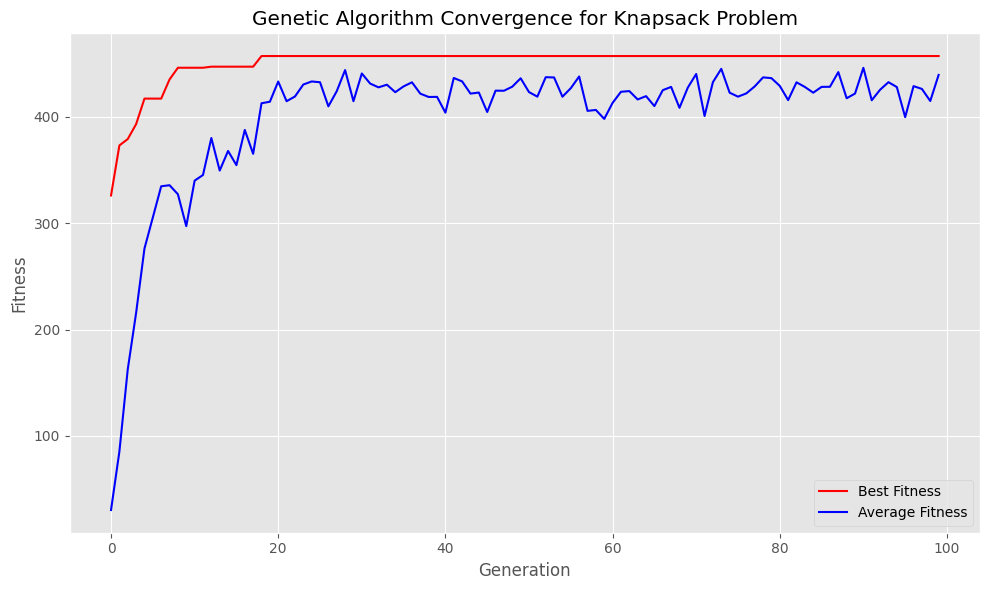

Time taken: 0.1464 seconds
Selected items: [1, 3, 6, 10, 13, 14, 16, 18, 19, 21, 22, 25, 26, 28, 29]
Total items selected: 15
Total weight: 68/68 (100.0%)
Total value: 457
--------------------------------------------------
Solving with Particle Swarm Optimization...


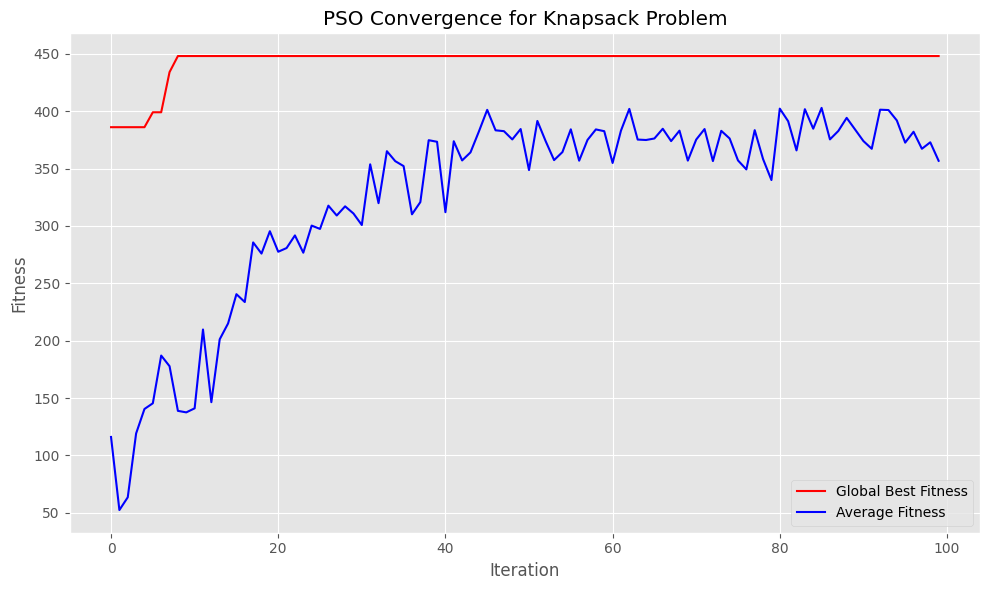

Time taken: 0.0754 seconds
Selected items: [1, 6, 11, 13, 14, 16, 18, 19, 20, 21, 22, 25, 26, 28]
Total items selected: 14
Total weight: 68/68 (100.0%)
Total value: 448
--------------------------------------------------


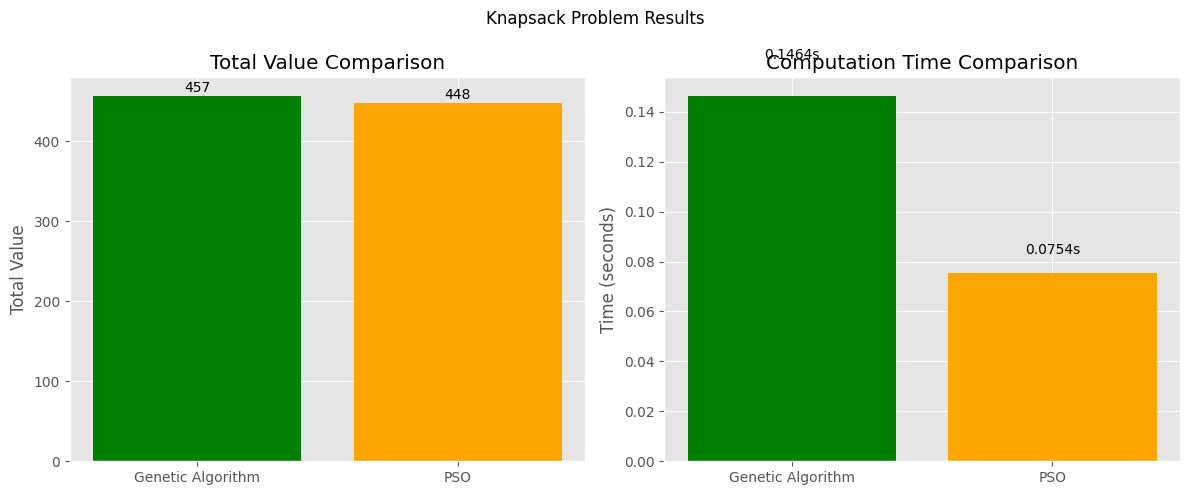

TRAVELING SALESMAN PROBLEM EXAMPLE
Problem size: 20 cities
--------------------------------------------------
Solving with Genetic Algorithm...


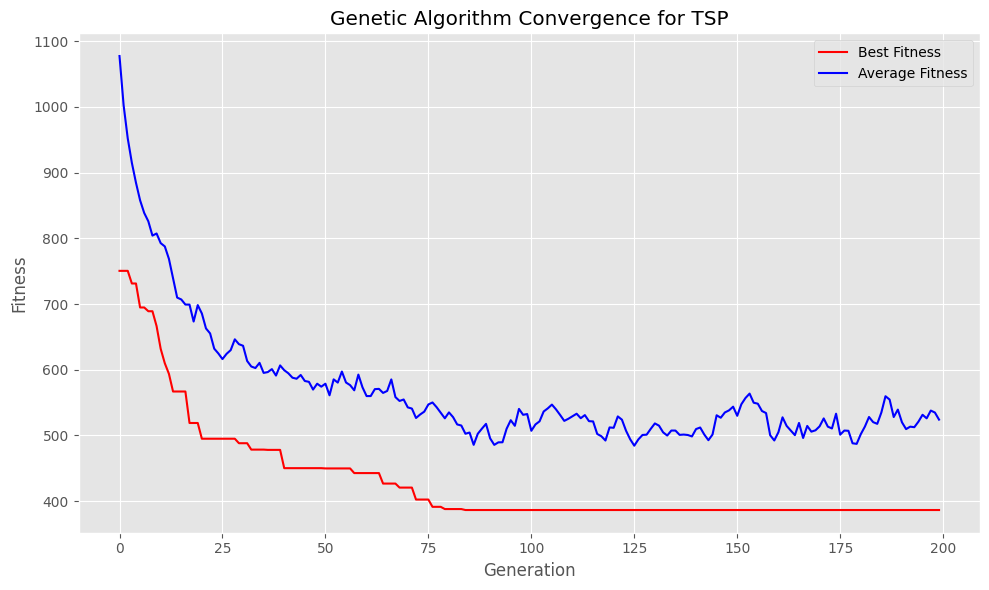

Time taken: 0.2451 seconds
Tour: [1, 19, 6, 15, 10, 14, 18, 2, 7, 9, 11, 8, 13, 3, 5, 16, 0, 12, 4, 17]
Tour length: 386.63
--------------------------------------------------
Solving with Particle Swarm Optimization...


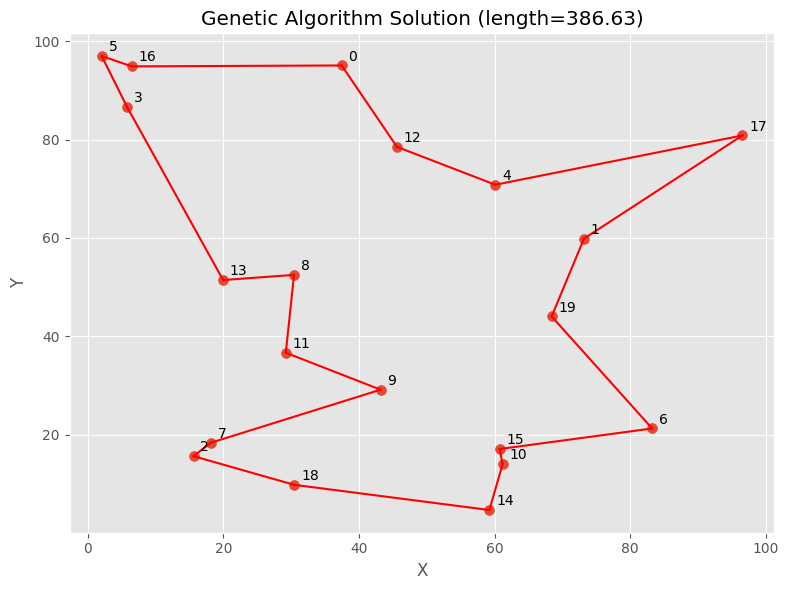

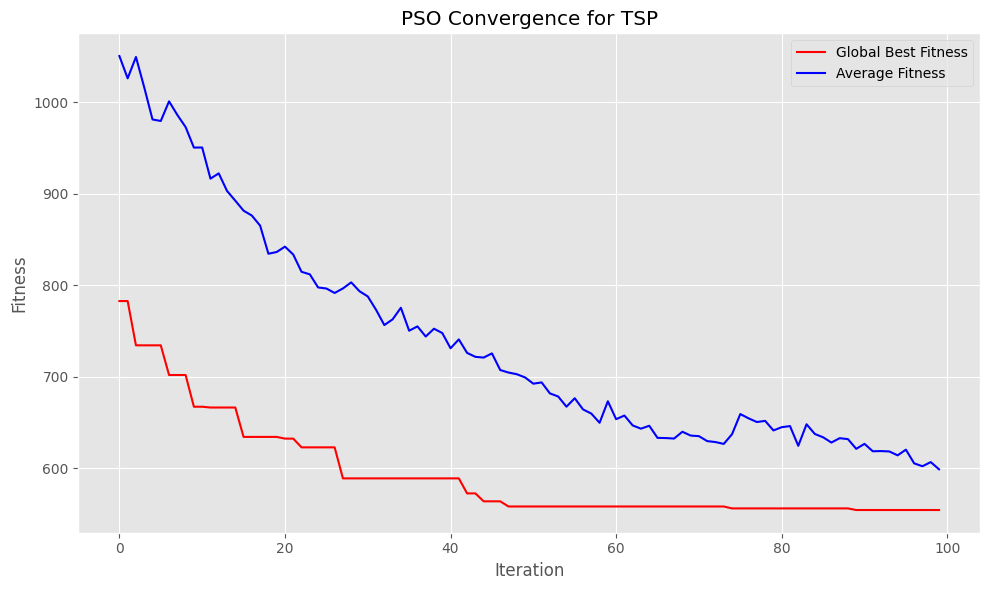

Time taken: 0.0438 seconds
Tour: [5, 3, 0, 16, 13, 9, 18, 14, 6, 10, 15, 19, 1, 17, 4, 12, 7, 2, 11, 8]
Tour length: 554.22
--------------------------------------------------


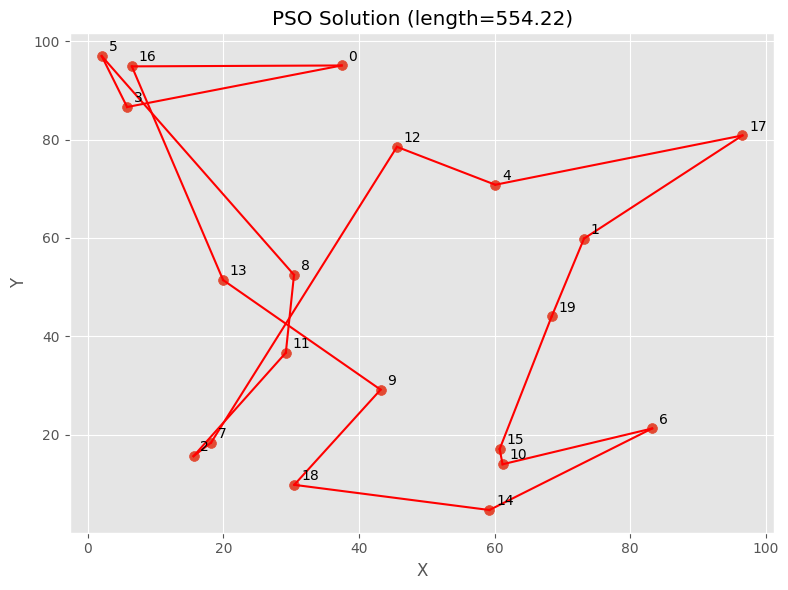

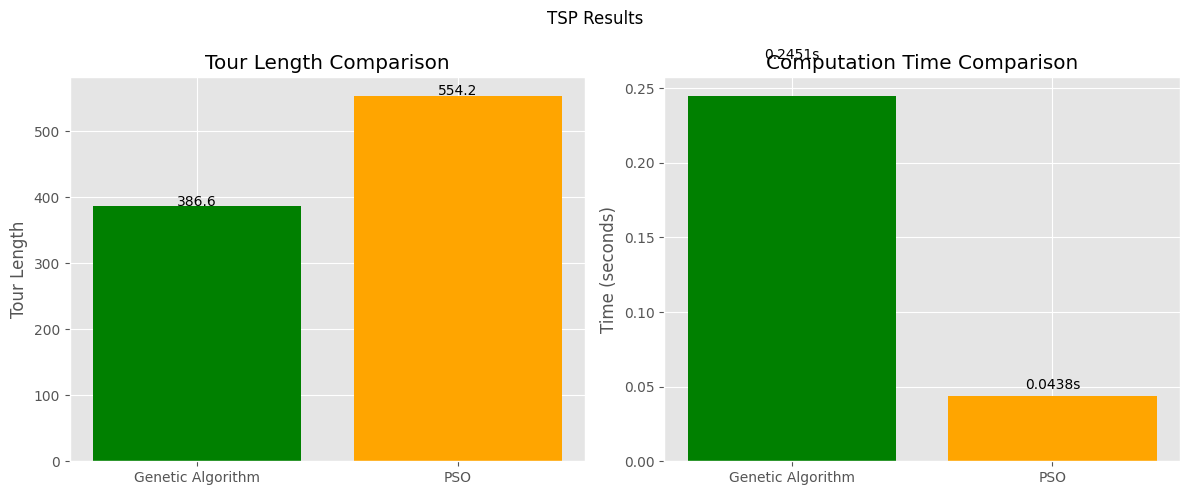

In [3]:
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Run Knapsack Problem
def run_knapsack_example():
    print("=" * 50)
    print("KNAPSACK PROBLEM EXAMPLE")
    print("=" * 50)
    
    # Generate a problem instance
    weights, values, capacity = generate_knapsack_instance(n=30)
    
    print(f"Problem size: {len(weights)} items")
    print(f"Total weight of all items: {sum(weights)}")
    print(f"Knapsack capacity: {capacity}")
    print("-" * 50)
    
    # Solve with Genetic Algorithm
    print("Solving with Genetic Algorithm...")
    selected_items_ga, time_ga = solve_knapsack_ga_from_scratch(
        weights, values, capacity, pop_size=100, max_generations=100
    )
    value_ga, _ = print_knapsack_solution(selected_items_ga, weights, values, capacity, time_ga)
    
    # Solve with PSO
    print("Solving with Particle Swarm Optimization...")
    selected_items_pso, time_pso = solve_knapsack_pso_from_scratch(
        weights, values, capacity, swarm_size=50, max_iterations=100
    )
    value_pso, _ = print_knapsack_solution(selected_items_pso, weights, values, capacity, time_pso)
    
    # Compare results
    results = {
        "Genetic Algorithm": {"value": value_ga, "time": time_ga},
        "PSO": {"value": value_pso, "time": time_pso}
    }
    
    visualize_knapsack_results(results)

# Run TSP Problem
def run_tsp_example():
    print("=" * 50)
    print("TRAVELING SALESMAN PROBLEM EXAMPLE")
    print("=" * 50)
    
    # Generate a problem instance
    n_cities = 20
    points, distances = generate_tsp_instance(n=n_cities)
    
    print(f"Problem size: {n_cities} cities")
    print("-" * 50)
    
    # Solve with Genetic Algorithm
    print("Solving with Genetic Algorithm...")
    tour_ga, time_ga = solve_tsp_ga_from_scratch(
        distances, pop_size=100, max_generations=200
    )
    length_ga, _ = print_tsp_solution(tour_ga, distances, time_ga)
    plot_tsp_solution(points, tour_ga, f"Genetic Algorithm Solution (length={length_ga:.2f})")
    
    # Solve with PSO
    print("Solving with Particle Swarm Optimization...")
    tour_pso, time_pso = solve_tsp_pso_from_scratch(
        distances, swarm_size=50, max_iterations=100
    )
    length_pso, _ = print_tsp_solution(tour_pso, distances, time_pso)
    plot_tsp_solution(points, tour_pso, f"PSO Solution (length={length_pso:.2f})")
    
    # Compare results
    results = {
        "Genetic Algorithm": {"length": length_ga, "time": time_ga},
        "PSO": {"length": length_pso, "time": time_pso}
    }
    
    visualize_tsp_results(results)

# Run examples
if __name__ == "__main__":
    # Run Knapsack example
    run_knapsack_example()
    
    # Run TSP example
    run_tsp_example()

ADVANCED METAHEURISTICS FOR TSP
Problem instance with 20 cities
--------------------------------------------------
Solving with Simulated Annealing...


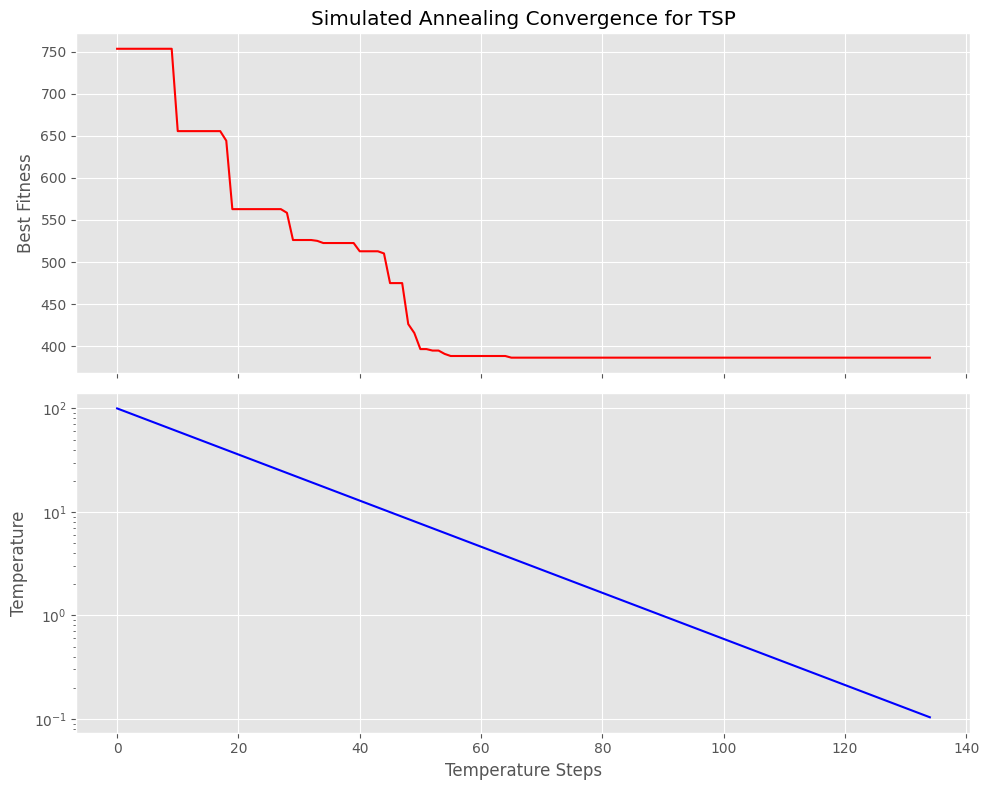

Time taken: 0.0634 seconds
Tour: [10, 15, 9, 18, 2, 7, 11, 8, 13, 3, 5, 16, 0, 12, 4, 17, 1, 19, 6, 14]
Tour length: 386.43
--------------------------------------------------
Solving with Ant Colony Optimization...


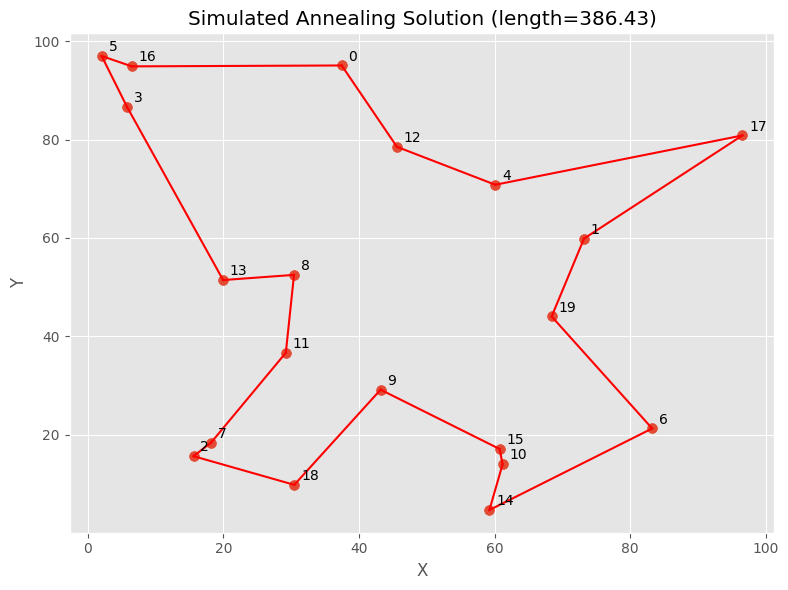

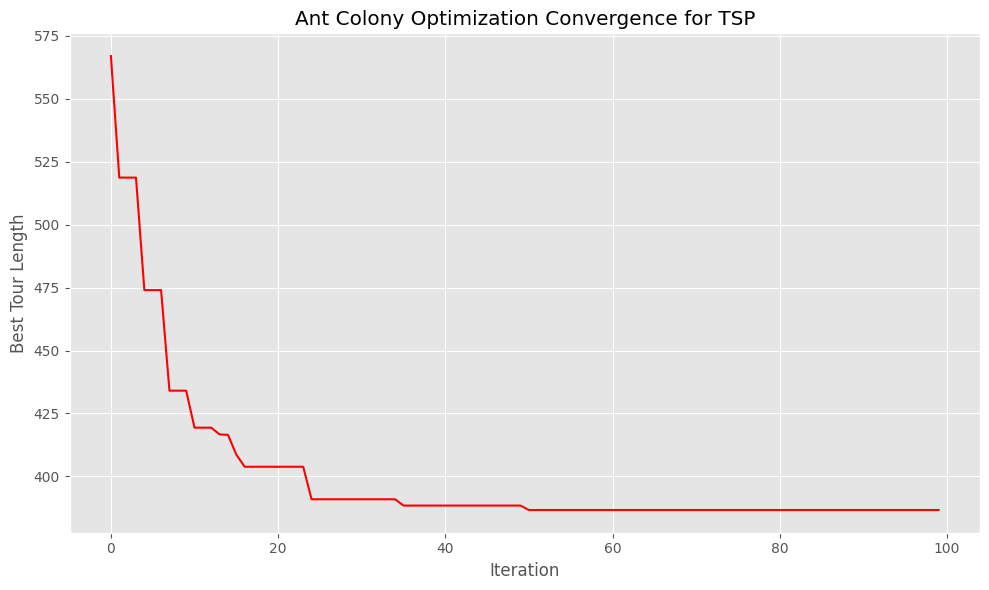

Time taken: 0.2649 seconds
Tour: [17, 1, 19, 6, 15, 10, 14, 18, 2, 7, 9, 11, 8, 13, 3, 5, 16, 0, 12, 4]
Tour length: 386.63
--------------------------------------------------


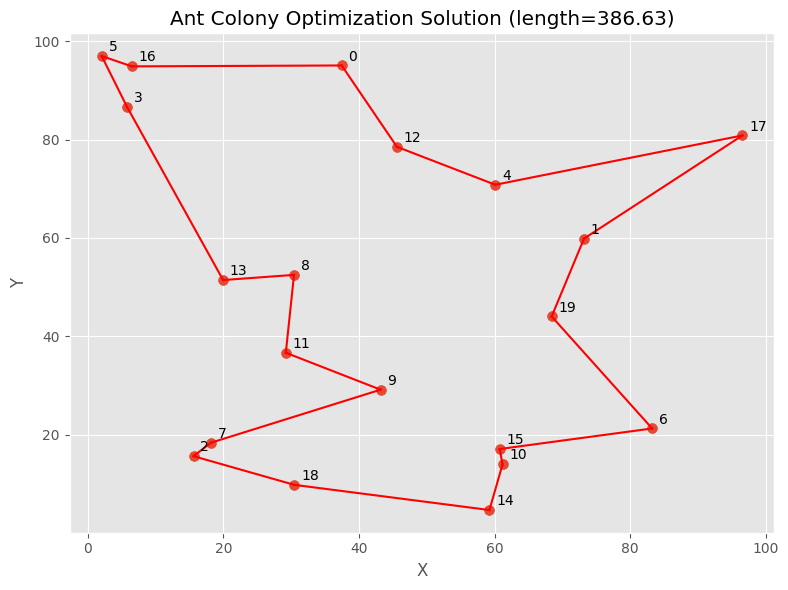

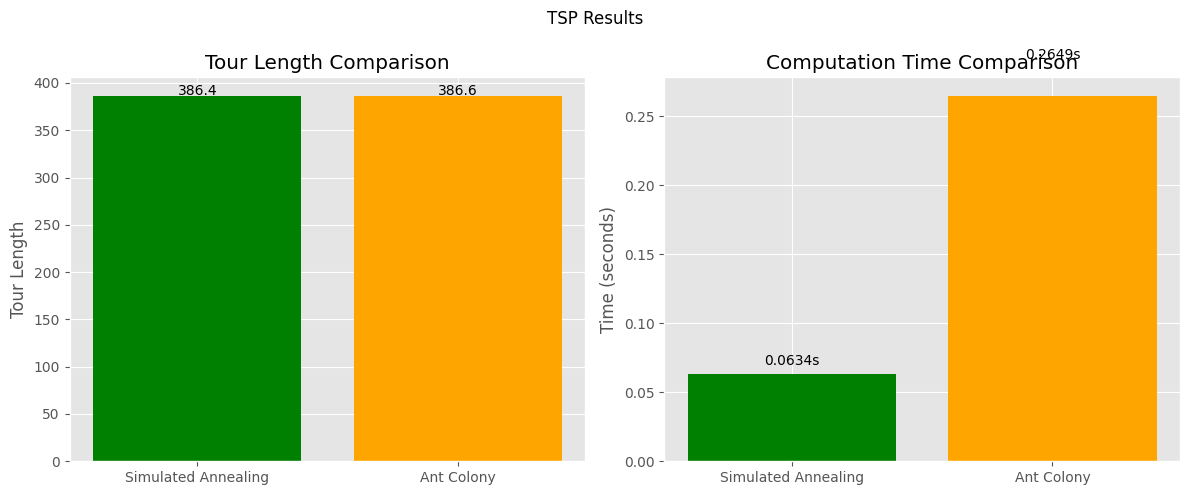

FUNCTION OPTIMIZATION WITH DIFFERENTIAL EVOLUTION
Optimizing 2D Rosenbrock function...


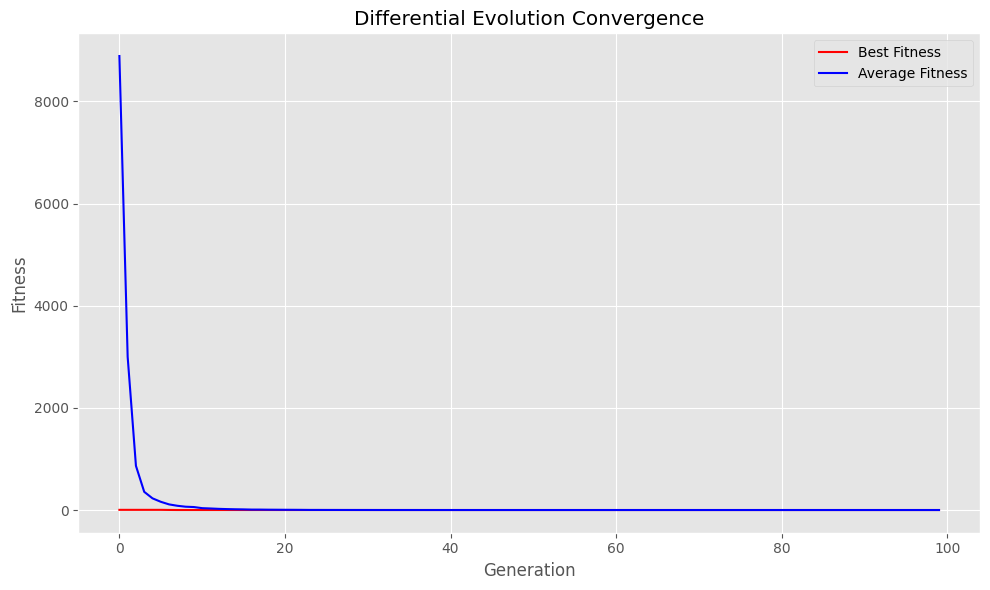

Time taken: 0.0148 seconds
Best solution: [0.9999914732379669, 0.9999831007504374]
Best fitness: 0.000000
Known global minimum: [1, 1] with f(x)=0
--------------------------------------------------
Optimizing 2D Rastrigin function...


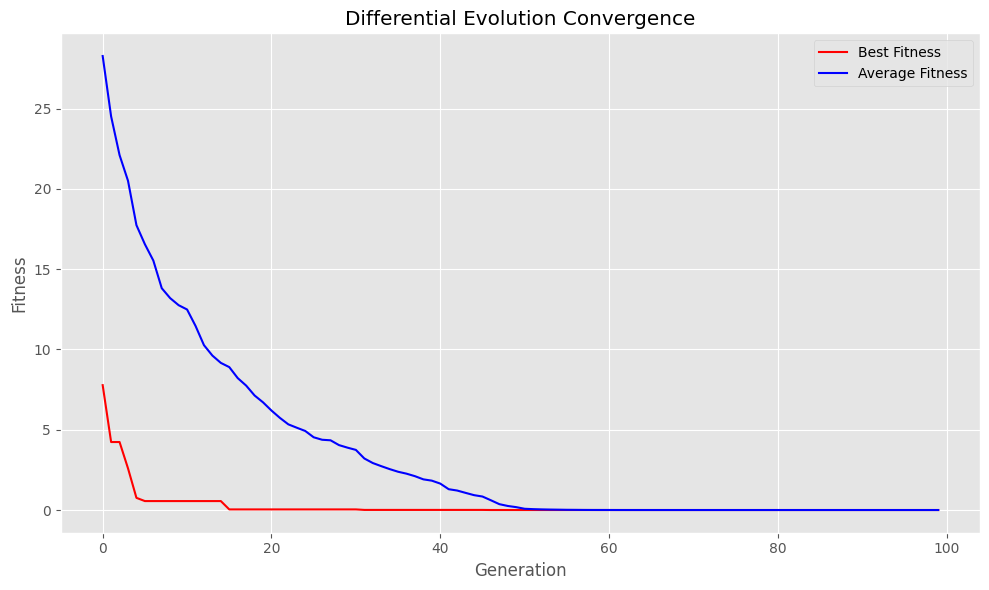

Time taken: 0.0191 seconds
Best solution: [1.1216942672496254e-07, 3.7206402021474586e-09]
Best fitness: 0.000000
Known global minimum: [0, 0] with f(x)=0
--------------------------------------------------
Optimizing 2D Ackley function...


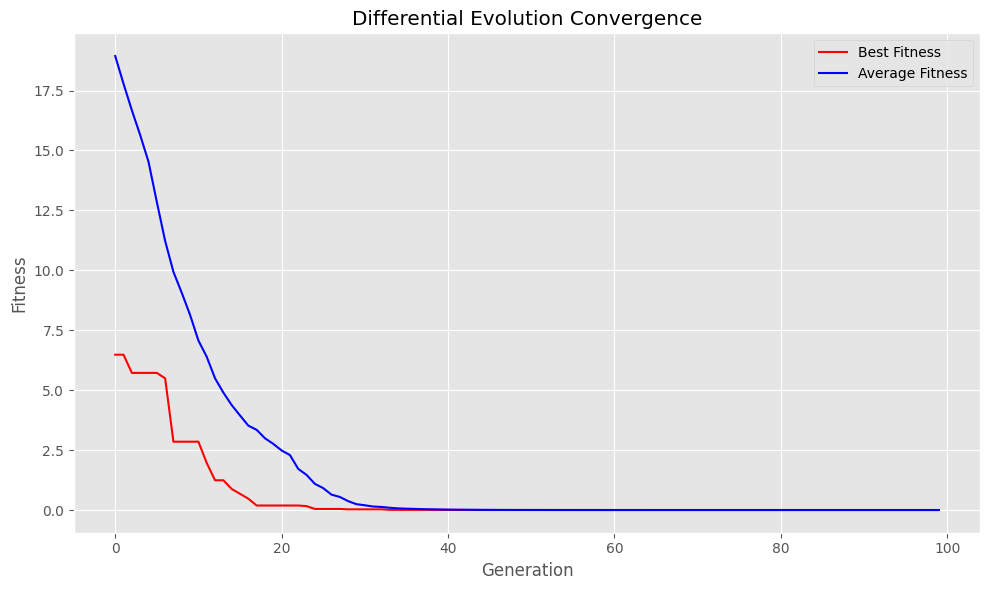

Time taken: 0.0288 seconds
Best solution: [4.417890209877832e-09, -9.600513417850559e-09]
Best fitness: 0.000000
Known global minimum: [0, 0] with f(x)=0
--------------------------------------------------


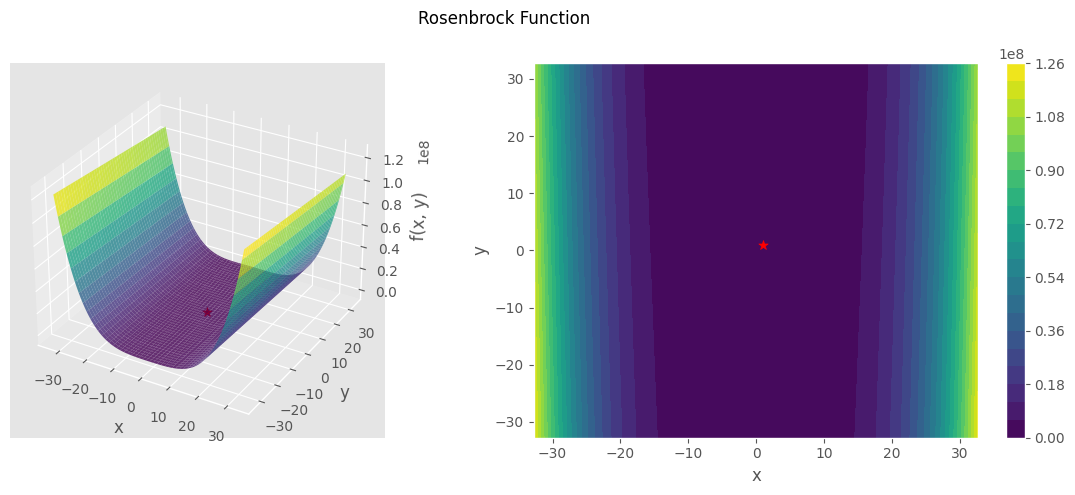

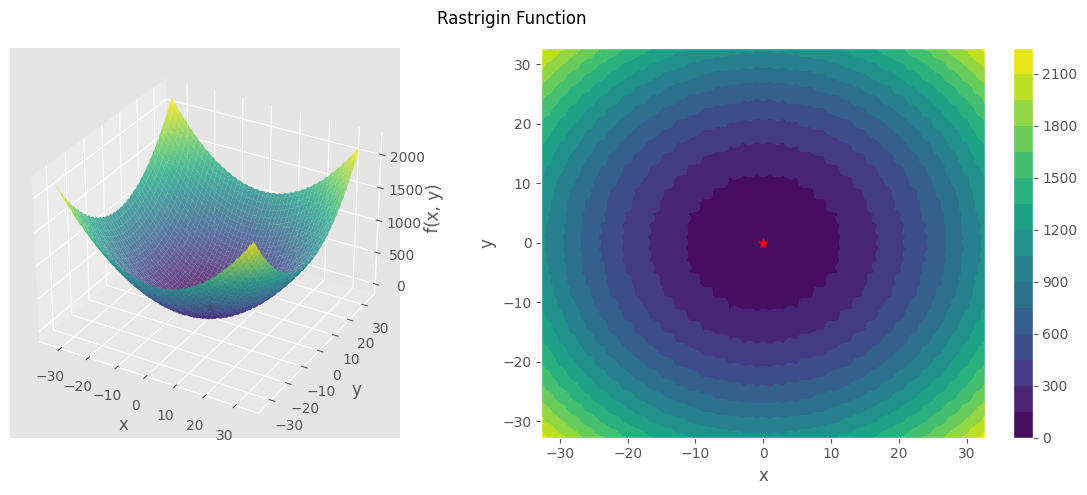

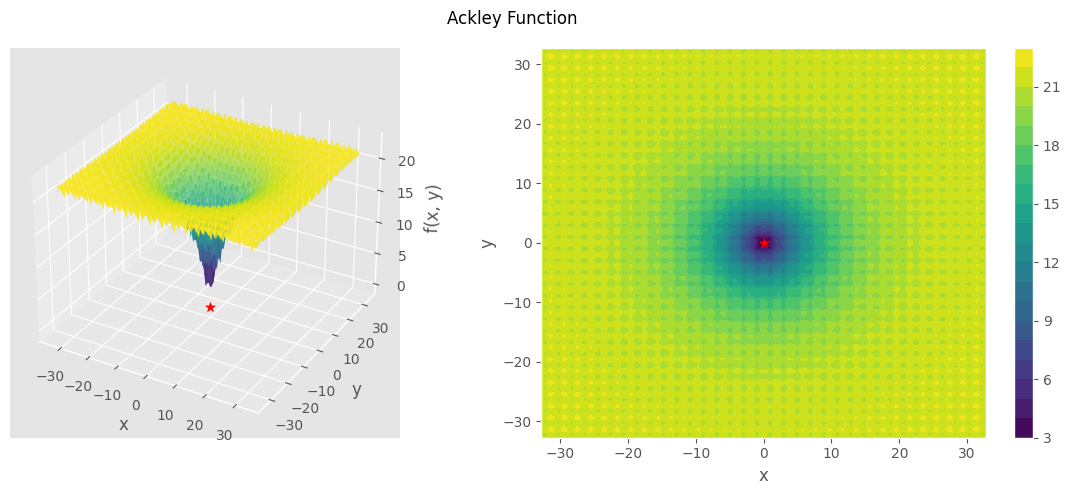

In [4]:
"""
Advanced Metaheuristics Implementations
=======================================

This module provides additional metaheuristic optimization techniques beyond the basic
Genetic Algorithm and Particle Swarm Optimization, including:

1. Simulated Annealing
2. Differential Evolution
3. Ant Colony Optimization

These implementations are created from scratch without specialized libraries,
ideal for educational purposes.
"""

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
from typing import List, Tuple, Dict, Callable, Any
import copy

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

#===========================================================
# SIMULATED ANNEALING FROM SCRATCH
#===========================================================

class SimulatedAnnealing:
    """
    Generic Simulated Annealing implementation from scratch.
    
    Simulated Annealing is inspired by the annealing process in metallurgy,
    where a material is heated and then cooled in a controlled manner to
    increase the size of its crystals and reduce defects.
    """
    
    def __init__(self, 
                 initial_temp: float = 100.0,
                 cooling_rate: float = 0.95,
                 min_temp: float = 0.1,
                 iterations_per_temp: int = 100):
        """
        Initialize the SA algorithm with parameters.
        
        Args:
            initial_temp: Starting temperature
            cooling_rate: Rate at which temperature decreases (0 < alpha < 1)
            min_temp: Stopping temperature
            iterations_per_temp: Number of iterations at each temperature
        """
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        self.iterations_per_temp = iterations_per_temp
        
        # For tracking
        self.best_solution_history = []
        self.best_fitness_history = []
        self.temperature_history = []
    
    def solve(self,
              initial_solution: Any,
              evaluate: Callable[[Any], float],
              generate_neighbor: Callable[[Any], Any],
              problem_type: str = "minimize") -> Tuple[Any, float]:
        """
        Solve an optimization problem using Simulated Annealing.
        
        Args:
            initial_solution: Initial candidate solution
            evaluate: Function that evaluates a solution and returns fitness
            generate_neighbor: Function that generates a neighboring solution
            problem_type: "minimize" or "maximize"
            
        Returns:
            Tuple of (best solution, best fitness)
        """
        # Initialize current solution and fitness
        current_solution = copy.deepcopy(initial_solution)
        current_fitness = evaluate(current_solution)
        
        # Initialize best solution and fitness
        best_solution = copy.deepcopy(current_solution)
        best_fitness = current_fitness
        
        # Initialize temperature
        temp = self.initial_temp
        
        iteration = 0
        
        # Main loop
        while temp > self.min_temp:
            self.temperature_history.append(temp)
            
            # Perform several iterations at current temperature
            for i in range(self.iterations_per_temp):
                iteration += 1
                
                # Generate a neighboring solution
                neighbor_solution = generate_neighbor(current_solution)
                neighbor_fitness = evaluate(neighbor_solution)
                
                # Calculate change in fitness
                delta_fitness = neighbor_fitness - current_fitness
                
                # Determine whether to accept the neighbor
                accept = False
                
                if problem_type == "minimize":
                    # For minimization, accept if fitness decreases
                    if delta_fitness <= 0:
                        accept = True
                    else:
                        # Accept with a probability that decreases with larger delta
                        # and as temperature decreases
                        accept_prob = math.exp(-delta_fitness / temp)
                        accept = random.random() < accept_prob
                else:  # maximize
                    # For maximization, accept if fitness increases
                    if delta_fitness >= 0:
                        accept = True
                    else:
                        # Accept with a probability that decreases with larger delta
                        # and as temperature decreases
                        accept_prob = math.exp(delta_fitness / temp)
                        accept = random.random() < accept_prob
                
                # Update current solution if accepted
                if accept:
                    current_solution = copy.deepcopy(neighbor_solution)
                    current_fitness = neighbor_fitness
                    
                    # Update best solution if better
                    if ((problem_type == "minimize" and current_fitness < best_fitness) or
                        (problem_type == "maximize" and current_fitness > best_fitness)):
                        best_solution = copy.deepcopy(current_solution)
                        best_fitness = current_fitness
            
            # Record best solution at this temperature
            self.best_solution_history.append(copy.deepcopy(best_solution))
            self.best_fitness_history.append(best_fitness)
            
            # Cool down
            temp *= self.cooling_rate
        
        return best_solution, best_fitness
    
    def plot_convergence(self, title: str = "Simulated Annealing Convergence"):
        """Plot the convergence of the algorithm."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        # Plot best fitness
        ax1.plot(self.best_fitness_history, 'r-')
        ax1.set_ylabel('Best Fitness')
        ax1.set_title(title)
        ax1.grid(True)
        
        # Plot temperature
        ax2.plot(self.temperature_history, 'b-')
        ax2.set_ylabel('Temperature')
        ax2.set_xlabel('Temperature Steps')
        ax2.set_yscale('log')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


#===========================================================
# DIFFERENTIAL EVOLUTION FROM SCRATCH
#===========================================================

class DifferentialEvolution:
    """
    Generic Differential Evolution implementation from scratch.
    
    Differential Evolution is a population-based optimization algorithm that
    uses vector differences for perturbing the vector population.
    """
    
    def __init__(self, 
                 pop_size: int = 50,
                 max_generations: int = 100,
                 crossover_rate: float = 0.7,
                 differential_weight: float = 0.8):
        """
        Initialize the DE algorithm with parameters.
        
        Args:
            pop_size: Population size
            max_generations: Maximum number of generations
            crossover_rate: Probability of crossover (CR)
            differential_weight: Differential weight (F)
        """
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.differential_weight = differential_weight
        
        # For tracking
        self.best_fitness_history = []
        self.avg_fitness_history = []
    
    def solve(self,
              init_individual: Callable[[], List[float]],
              evaluate: Callable[[List[float]], float],
              bounds: List[Tuple[float, float]],
              problem_type: str = "minimize") -> Tuple[List[float], float]:
        """
        Solve an optimization problem using Differential Evolution.
        
        Args:
            init_individual: Function that returns a new random individual
            evaluate: Function that evaluates an individual and returns fitness
            bounds: List of (min, max) bounds for each dimension
            problem_type: "minimize" or "maximize"
            
        Returns:
            Tuple of (best individual, best fitness)
        """
        # Determine dimensionality from bounds
        n_dims = len(bounds)
        
        # Initialize population
        population = []
        fitness = []
        
        for i in range(self.pop_size):
            ind = init_individual()
            population.append(ind)
            fitness.append(evaluate(ind))
        
        # Main loop
        for generation in range(self.max_generations):
            # Create new generation
            for i in range(self.pop_size):
                # Select three random individuals different from i and from each other
                candidates = list(range(self.pop_size))
                candidates.remove(i)
                r1, r2, r3 = random.sample(candidates, 3)
                
                # Create mutant vector using DE/rand/1 strategy
                mutant = []
                for j in range(n_dims):
                    # DE/rand/1 formula: v = x_r1 + F * (x_r2 - x_r3)
                    value = population[r1][j] + self.differential_weight * (
                        population[r2][j] - population[r3][j])
                    
                    # Bound within limits
                    value = max(min(value, bounds[j][1]), bounds[j][0])
                    mutant.append(value)
                
                # Create trial vector through crossover
                trial = []
                for j in range(n_dims):
                    if random.random() < self.crossover_rate or j == random.randint(0, n_dims - 1):
                        trial.append(mutant[j])
                    else:
                        trial.append(population[i][j])
                
                # Evaluate trial vector
                trial_fitness = evaluate(trial)
                
                # Selection
                if ((problem_type == "minimize" and trial_fitness <= fitness[i]) or 
                    (problem_type == "maximize" and trial_fitness >= fitness[i])):
                    population[i] = trial
                    fitness[i] = trial_fitness
            
            # Track statistics
            if problem_type == "minimize":
                best_idx = np.argmin(fitness)
                best_fitness = min(fitness)
            else:
                best_idx = np.argmax(fitness)
                best_fitness = max(fitness)
                
            avg_fitness = np.mean(fitness)
            self.best_fitness_history.append(best_fitness)
            self.avg_fitness_history.append(avg_fitness)
        
        # Return best individual
        if problem_type == "minimize":
            best_idx = np.argmin(fitness)
        else:
            best_idx = np.argmax(fitness)
            
        return population[best_idx], fitness[best_idx]
    
    def plot_convergence(self, title: str = "Differential Evolution Convergence"):
        """Plot the convergence of the algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_fitness_history, 'r-', label='Best Fitness')
        plt.plot(self.avg_fitness_history, 'b-', label='Average Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#===========================================================
# ANT COLONY OPTIMIZATION FROM SCRATCH
#===========================================================

class AntColonyOptimization:
    """
    Generic Ant Colony Optimization implementation from scratch.
    
    ACO is inspired by the foraging behavior of ants, which find paths
    between their colony and food sources by depositing pheromones.
    """
    
    def __init__(self, 
                 n_ants: int = 30,
                 max_iterations: int = 100,
                 evaporation_rate: float = 0.5,
                 alpha: float = 1.0,  # Pheromone importance
                 beta: float = 2.0):  # Heuristic importance
        """
        Initialize the ACO algorithm with parameters.
        
        Args:
            n_ants: Number of ants
            max_iterations: Maximum number of iterations
            evaporation_rate: Pheromone evaporation rate (0 < rho < 1)
            alpha: Weight of pheromone information
            beta: Weight of heuristic information
        """
        self.n_ants = n_ants
        self.max_iterations = max_iterations
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        
        # These will be set in the solve_tsp method
        self.distances = None
        self.n_cities = None
        self.pheromones = None
        
        # For tracking
        self.best_solution_history = []
        self.best_fitness_history = []
    
    def solve_tsp(self, distances: np.ndarray) -> Tuple[List[int], float]:
        """
        Solve the Traveling Salesman Problem using ACO.
        
        Args:
            distances: Distance matrix
            
        Returns:
            Tuple of (best tour, best tour length)
        """
        # Store problem data
        self.distances = distances
        self.n_cities = distances.shape[0]
        
        # Initialize pheromone matrix
        # Initially all edges have equal pheromone levels
        self.pheromones = np.ones((self.n_cities, self.n_cities))
        
        # Track best solution
        best_tour = None
        best_length = float('inf')
        
        # Main loop
        for iteration in range(self.max_iterations):
            # Generate tours for all ants
            all_tours = []
            all_lengths = []
            
            for ant in range(self.n_ants):
                # Construct a tour
                tour = self._construct_tour()
                
                # Calculate tour length
                tour_length = self._calculate_tour_length(tour)
                
                all_tours.append(tour)
                all_lengths.append(tour_length)
                
                # Update best solution if better
                if tour_length < best_length:
                    best_tour = tour.copy()
                    best_length = tour_length
            
            # Track best solution for this iteration
            self.best_solution_history.append(best_tour.copy())
            self.best_fitness_history.append(best_length)
            
            # Update pheromones
            self._update_pheromones(all_tours, all_lengths)
        
        return best_tour, best_length
    
    def _construct_tour(self) -> List[int]:
        """
        Construct a tour for an ant using the pheromone and heuristic information.
        
        Returns:
            A tour (list of city indices)
        """
        # Start from a random city
        current_city = random.randint(0, self.n_cities - 1)
        
        # Initialize tour
        tour = [current_city]
        unvisited = set(range(self.n_cities))
        unvisited.remove(current_city)
        
        # Construct tour by visiting each unvisited city
        while unvisited:
            # Calculate probabilities of visiting each unvisited city
            probabilities = []
            
            for city in unvisited:
                # Calculate pheromone and heuristic values
                pheromone = self.pheromones[current_city, city] ** self.alpha
                heuristic = (1.0 / self.distances[current_city, city]) ** self.beta
                
                probability = pheromone * heuristic
                probabilities.append((city, probability))
            
            # Sort by probability
            probabilities.sort(key=lambda x: x[1], reverse=True)
            
            # Select next city using roulette wheel selection
            total = sum(prob for _, prob in probabilities)
            
            if total == 0:  # If all probabilities are zero, choose randomly
                next_city = random.choice(list(unvisited))
            else:
                r = random.uniform(0, total)
                cumsum = 0
                next_city = probabilities[0][0]  # Default in case of rounding errors
                
                for city, prob in probabilities:
                    cumsum += prob
                    if cumsum >= r:
                        next_city = city
                        break
            
            # Add to tour
            tour.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
        
        return tour
    
    def _calculate_tour_length(self, tour: List[int]) -> float:
        """Calculate the length of a tour."""
        length = 0
        for i in range(len(tour)):
            from_city = tour[i]
            to_city = tour[(i + 1) % len(tour)]
            length += self.distances[from_city, to_city]
        return length
    
    def _update_pheromones(self, all_tours: List[List[int]], all_lengths: List[float]) -> None:
        """
        Update pheromones based on tour quality.
        
        Args:
            all_tours: List of tours (one for each ant)
            all_lengths: List of tour lengths
        """
        # Evaporate pheromones on all edges
        self.pheromones *= (1 - self.evaporation_rate)
        
        # Add new pheromones based on tour quality
        for tour, length in zip(all_tours, all_lengths):
            # Amount of pheromone to deposit is inverse to tour length
            deposit = 1.0 / length
            
            for i in range(len(tour)):
                from_city = tour[i]
                to_city = tour[(i + 1) % len(tour)]
                
                self.pheromones[from_city, to_city] += deposit
                self.pheromones[to_city, from_city] += deposit  # Symmetric TSP
    
    def plot_convergence(self, title: str = "Ant Colony Optimization Convergence"):
        """Plot the convergence of the algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_fitness_history, 'r-')
        plt.xlabel('Iteration')
        plt.ylabel('Best Tour Length')
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#===========================================================
# EXAMPLE: Solving TSP with Advanced Metaheuristics
#===========================================================

def solve_tsp_sa(distances: np.ndarray, 
                initial_temp: float = 100.0, 
                cooling_rate: float = 0.95,
                iterations_per_temp: int = 100) -> Tuple[List[int], float]:
    """Solve the TSP using Simulated Annealing."""
    start_time = time.time()
    n = distances.shape[0]
    
    # Initialize SA
    sa = SimulatedAnnealing(
        initial_temp=initial_temp,
        cooling_rate=cooling_rate,
        min_temp=0.1,
        iterations_per_temp=iterations_per_temp
    )
    
    # Define functions for SA
    def initial_solution():
        """Create a random tour."""
        tour = list(range(n))
        random.shuffle(tour)
        return tour
    
    def evaluate(tour):
        """Calculate total tour length."""
        return sum(distances[tour[i], tour[(i + 1) % n]] for i in range(n))
    
    def generate_neighbor(tour):
        """
        Generate a neighboring tour using one of these strategies:
        1. Swap two random cities
        2. Reverse a random segment
        """
        new_tour = tour.copy()
        
        # Randomly choose a neighborhood strategy
        strategy = random.choice(['swap', 'reverse'])
        
        if strategy == 'swap':
            # Swap two random cities
            i, j = random.sample(range(n), 2)
            new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
        else:
            # Reverse a random segment
            i, j = random.sample(range(n), 2)
            if i > j:
                i, j = j, i
            new_tour[i:j+1] = reversed(new_tour[i:j+1])
        
        return new_tour
    
    # Solve using SA
    initial = initial_solution()
    best_tour, best_length = sa.solve(
        initial_solution=initial,
        evaluate=evaluate,
        generate_neighbor=generate_neighbor,
        problem_type="minimize"
    )
    
    end_time = time.time()
    
    # Plot convergence
    sa.plot_convergence(title="Simulated Annealing Convergence for TSP")
    
    return best_tour, end_time - start_time

def solve_tsp_aco(distances: np.ndarray, 
                 n_ants: int = 30, 
                 max_iterations: int = 100) -> Tuple[List[int], float]:
    """Solve the TSP using Ant Colony Optimization."""
    start_time = time.time()
    
    # Initialize ACO
    aco = AntColonyOptimization(
        n_ants=n_ants,
        max_iterations=max_iterations,
        evaporation_rate=0.5,
        alpha=1.0,
        beta=2.0
    )
    
    # Solve using ACO
    best_tour, best_length = aco.solve_tsp(distances)
    
    end_time = time.time()
    
    # Plot convergence
    aco.plot_convergence(title="Ant Colony Optimization Convergence for TSP")
    
    return best_tour, end_time - start_time

def demonstrate_advanced_tsp():
    """Demonstrate TSP solving with advanced metaheuristics."""
    print("=" * 50)
    print("ADVANCED METAHEURISTICS FOR TSP")
    print("=" * 50)
    
    # Generate problem instance
    n = 20
    points, distances = generate_tsp_instance(n=n)
    
    print(f"Problem instance with {n} cities")
    print("-" * 50)
    
    # Solve with Simulated Annealing
    print("Solving with Simulated Annealing...")
    tour_sa, time_sa = solve_tsp_sa(distances)
    length_sa = sum(distances[tour_sa[i], tour_sa[(i + 1) % n]] for i in range(n))
    print(f"Time taken: {time_sa:.4f} seconds")
    print(f"Tour: {tour_sa}")
    print(f"Tour length: {length_sa:.2f}")
    print("-" * 50)
    plot_tsp_solution(points, tour_sa, f"Simulated Annealing Solution (length={length_sa:.2f})")
    
    # Solve with Ant Colony Optimization
    print("Solving with Ant Colony Optimization...")
    tour_aco, time_aco = solve_tsp_aco(distances)
    length_aco = sum(distances[tour_aco[i], tour_aco[(i + 1) % n]] for i in range(n))
    print(f"Time taken: {time_aco:.4f} seconds")
    print(f"Tour: {tour_aco}")
    print(f"Tour length: {length_aco:.2f}")
    print("-" * 50)
    plot_tsp_solution(points, tour_aco, f"Ant Colony Optimization Solution (length={length_aco:.2f})")
    
    # Visualize results
    results = {
        "Simulated Annealing": {"length": length_sa, "time": time_sa},
        "Ant Colony": {"length": length_aco, "time": time_aco}
    }
    
    visualize_tsp_results(results)

#===========================================================
# EXAMPLE: Solving Function Optimization with DE
#===========================================================

def solve_function_de(func, bounds, max_generations=100):
    """
    Solve a function optimization problem using Differential Evolution.
    
    Args:
        func: The function to optimize (minimize)
        bounds: List of (min, max) bounds for each dimension
        max_generations: Maximum number of generations
        
    Returns:
        Tuple of (best solution, best fitness)
    """
    start_time = time.time()
    n_dims = len(bounds)
    
    # Initialize DE
    de = DifferentialEvolution(
        pop_size=50,
        max_generations=max_generations,
        crossover_rate=0.7,
        differential_weight=0.8
    )
    
    # Define functions for DE
    def init_individual():
        """Create a random solution within bounds."""
        return [random.uniform(bounds[i][0], bounds[i][1]) for i in range(n_dims)]
    
    def evaluate(solution):
        """Evaluate the function value."""
        return func(solution)
    
    # Solve using DE
    best_solution, best_fitness = de.solve(
        init_individual=init_individual,
        evaluate=evaluate,
        bounds=bounds,
        problem_type="minimize"
    )
    
    end_time = time.time()
    
    # Plot convergence
    de.plot_convergence(title="Differential Evolution Convergence")
    
    return best_solution, best_fitness, end_time - start_time

def demonstrate_function_optimization():
    """Demonstrate function optimization with DE."""
    print("=" * 50)
    print("FUNCTION OPTIMIZATION WITH DIFFERENTIAL EVOLUTION")
    print("=" * 50)
    
    # Example functions to optimize
    
    # Rosenbrock function (banana function)
    # Global minimum at (1,1,...,1) with f(x)=0
    def rosenbrock(x):
        return sum(100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1))
    
    # Rastrigin function
    # Global minimum at (0,0,...,0) with f(x)=0
    def rastrigin(x):
        return 10 * len(x) + sum(xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x)
    
    # Ackley function
    # Global minimum at (0,0,...,0) with f(x)=0
    def ackley(x):
        a, b, c = 20, 0.2, 2 * np.pi
        d = len(x)
        sum1 = sum(xi**2 for xi in x) / d
        sum2 = sum(np.cos(c * xi) for xi in x) / d
        return -a * np.exp(-b * np.sqrt(sum1)) - np.exp(sum2) + a + np.exp(1)
    
    # Solve Rosenbrock function (2D)
    print("Optimizing 2D Rosenbrock function...")
    bounds = [(-5, 5)] * 2
    solution_rosenbrock, fitness_rosenbrock, time_rosenbrock = solve_function_de(
        rosenbrock, bounds
    )
    print(f"Time taken: {time_rosenbrock:.4f} seconds")
    print(f"Best solution: {solution_rosenbrock}")
    print(f"Best fitness: {fitness_rosenbrock:.6f}")
    print(f"Known global minimum: [1, 1] with f(x)=0")
    print("-" * 50)
    
    # Solve Rastrigin function (2D)
    print("Optimizing 2D Rastrigin function...")
    bounds = [(-5.12, 5.12)] * 2
    solution_rastrigin, fitness_rastrigin, time_rastrigin = solve_function_de(
        rastrigin, bounds
    )
    print(f"Time taken: {time_rastrigin:.4f} seconds")
    print(f"Best solution: {solution_rastrigin}")
    print(f"Best fitness: {fitness_rastrigin:.6f}")
    print(f"Known global minimum: [0, 0] with f(x)=0")
    print("-" * 50)
    
    # Solve Ackley function (2D)
    print("Optimizing 2D Ackley function...")
    bounds = [(-32.768, 32.768)] * 2
    solution_ackley, fitness_ackley, time_ackley = solve_function_de(
        ackley, bounds
    )
    print(f"Time taken: {time_ackley:.4f} seconds")
    print(f"Best solution: {solution_ackley}")
    print(f"Best fitness: {fitness_ackley:.6f}")
    print(f"Known global minimum: [0, 0] with f(x)=0")
    print("-" * 50)
    
    # Visualize the functions and solutions in 2D
    visualize_2d_function(rosenbrock, bounds, solution_rosenbrock, "Rosenbrock Function")
    visualize_2d_function(rastrigin, bounds, solution_rastrigin, "Rastrigin Function")
    visualize_2d_function(ackley, bounds, solution_ackley, "Ackley Function")

def visualize_2d_function(func, bounds, solution, title):
    """Visualize a 2D function and the found solution."""
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    # Create grid
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)
    
    # Calculate function values
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func([X[i, j], Y[i, j]])
    
    # Plot surface
    fig = plt.figure(figsize=(12, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('f(x, y)')
    
    # Mark the solution
    ax1.scatter(solution[0], solution[1], func(solution), 
                color='red', s=50, marker='*')
    
    # Contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, Z, 20, cmap='viridis')
    fig.colorbar(contour, ax=ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    # Mark the solution
    ax2.scatter(solution[0], solution[1], color='red', s=50, marker='*')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#===========================================================
# MAIN: Demonstrate all methods
#===========================================================

def main():
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    
    
    # Run TSP demonstration with advanced metaheuristics
    demonstrate_advanced_tsp()
    
    # Run function optimization demonstration
    demonstrate_function_optimization()

if __name__ == "__main__":
    main()